# Prepare and check environment

Check that nvidia GPU is ready

In [ ]:
!nvidia-smi

Wed Dec 20 17:58:37 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Install ultralytics and check it

In [ ]:
!pip install ultralytics
!clear

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


# Prepare dataset

Download dataset from google drive and then extract it.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!echo "Copying dataset..."
!cp /content/gdrive/MyDrive/Datasets/panda-data.tar.xz .
!echo "Umount google drive..."
drive.flush_and_unmount()
!echo "Dataset was copied:"
!ls

!echo "Extracting dataset..."
!tar -xf panda-data.tar.xz
!echo "Dataset was extracted:"
!ls panda-data

Mounted at /content/gdrive
Copying dataset...
Umount google drive...
Dataset was copied:
panda-data.tar.xz
Extracting dataset...
Dataset was extracted:
hand-testing  panda-dataset


# See dataset content

`panda-data` folder contains two folder: hand-testing and panda-dataset. The dataset consists of three folders: `train`, `val` and `test`. The first one contains images for training the neural network, the second one for validation, and the last one for testing.  The dataset is in a format that YOLA8 understands: https://docs.ultralytics.com/datasets/classify/#dataset-format.

There are a total of two classes of images in this model: images with a red panda and images without a red panda. Images in the folders `test`, `val`, `train` are not repeated.

Count images at different folders:

In [ ]:
import os

DATASET_PATH = os.path.join("panda-data", "panda-dataset")

def count_files_at_classes(path_to_folder: str) -> dict:
  res = {}
  for dir in os.listdir(path_to_folder):
    curr_dir_path = os.path.join(path_to_folder, dir)
    if os.path.isdir(curr_dir_path):
      res[dir] = len([file for file in os.listdir(curr_dir_path) if os.path.isfile(os.path.join(curr_dir_path, file))])

  return res

def count_files(path_to_dataset: str) -> dict:
  res = {}
  for dir in os.listdir(path_to_dataset):
    curr_dir_path = os.path.join(path_to_dataset, dir)
    if os.path.isdir(curr_dir_path):
      res[dir] = count_files_at_classes(curr_dir_path)

  return res

print("Number of files:")
for folder_type, classes in count_files(DATASET_PATH).items():
  print(folder_type)
  for _class, _number in classes.items():
    print("\t{}: {}".format(_class, _number))

Number of files:
train
	no-red-panda: 2575
	red-panda: 1006
test
	no-red-panda: 48
	red-panda: 100
val
	no-red-panda: 291
	red-panda: 276


The images described above are used to train the neural network and test it using the features provided by YOLA8. In addition, there is a folder `hand-testing` containing images for my own testing of image identification in various animal photos.

#Train neural network

In [9]:
!echo "Clear previous run"
!rm -rf runs

Clear previous run


Dataset is prepared in format which YOLA expects.

The parameters chosen to train the neural network were determined empirically.

In [10]:
import os
from ultralytics import YOLO

# Load model
model = YOLO("yolov8n-cls.pt")

# Train model on dataset
trained_model = model.train(data=DATASET_PATH, epochs=20, imgsz=64)

Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=panda-data/panda-dataset, epochs=20, time=None, patience=50, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None,

train: Scanning /content/panda-data/panda-dataset/train... 3581 images, 0 corrupt: 100%|██████████| 3581/3581 [00:00<?, ?it/s]

albumentations: RandomResizedCrop(p=1.0, height=64, width=64, scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1), HorizontalFlip(p=0.5), ColorJitter(p=0.5, brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.30000000000000004, 1.7], hue=[-0.015, 0.015]), Normalize(p=1.0, mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), max_pixel_value=255.0), ToTensorV2(always_apply=True, p=1.0, transpose_mask=False)



val: Scanning /content/panda-data/panda-dataset/val... 567 images, 0 corrupt: 100%|██████████| 567/567 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.98it/s]

                   all      0.899          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  5.96it/s]

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:04<00:00,  4.43it/s]

                   all      0.949          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  5.60it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  5.55it/s]

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]

                   all      0.961          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  5.03it/s]

                   all      0.959          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  5.34it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:04<00:00,  3.70it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20     0.382G    0.06458         13         64: 100%|██████████| 224/224 [00:34<00:00,  6.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:02<00:00,  6.38it/s]

                   all      0.961          1



      Epoch    GPU_mem       loss  Instances       Size


      11/20     0.384G    0.06851         13         64: 100%|██████████| 224/224 [00:36<00:00,  6.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  5.52it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


      12/20     0.382G    0.05149         13         64: 100%|██████████| 224/224 [00:34<00:00,  6.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:04<00:00,  3.83it/s]

                   all      0.974          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20     0.382G    0.04431         13         64: 100%|██████████| 224/224 [00:34<00:00,  6.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  5.66it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20     0.382G    0.05838         13         64: 100%|██████████| 224/224 [00:35<00:00,  6.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.64it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


      15/20     0.382G    0.05121         13         64: 100%|██████████| 224/224 [00:34<00:00,  6.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.60it/s]

                   all      0.981          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20     0.382G    0.04183         13         64: 100%|██████████| 224/224 [00:35<00:00,  6.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:02<00:00,  6.23it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20     0.382G    0.04626         13         64: 100%|██████████| 224/224 [00:35<00:00,  6.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.80it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20     0.382G    0.04186         13         64: 100%|██████████| 224/224 [00:34<00:00,  6.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  4.86it/s]

                   all      0.981          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20     0.382G    0.03417         13         64: 100%|██████████| 224/224 [00:35<00:00,  6.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  5.42it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20     0.382G    0.02798         13         64: 100%|██████████| 224/224 [00:35<00:00,  6.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:04<00:00,  4.05it/s]

                   all      0.981          1



20 epochs completed in 0.221 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics YOLOv8.0.228 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1437442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/panda-data/panda-dataset/train... found 3581 images in 2 classes ✅ 
val: /content/panda-data/panda-dataset/val... found 567 images in 2 classes ✅ 
test: /content/panda-data/panda-dataset/test... found 148 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:03<00:00,  5.31it/s]


                   all      0.981          1
Speed: 0.2ms preprocess, 1.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
Results saved to runs/classify/train


In this table and graph, we can observe how the accuracy and loss rates changed during model training. In addition, we can see that the accuracy of the model is 98.1% on the data in the `test` directory.

Runs result:

In [84]:
import pandas as pd

data = pd.read_csv('/content/runs/classify/train/results.csv')
data

,epoch,train/loss,metrics/accuracy_top1,metrics/accuracy_top5,val/loss,lr/pg0,lr/pg1,lr/pg2
0,1,0.43252,0.89947,1,0.42217,0.000237,0.000237,0.000237
1,2,0.20707,0.91358,1,0.40190,0.000451,0.000451,0.000451
2,3,0.18180,0.94885,1,0.37200,0.000642,0.000642,0.000642
3,4,0.14634,0.94709,1,0.37916,0.000608,0.000608,0.000608
4,5,0.15212,0.94004,1,0.38040,0.000608,0.000608,0.000608
5,6,0.11078,0.96120,1,0.36294,0.000573,0.000573,0.000573
6,7,0.09969,0.95944,1,0.36270,0.000537,0.000537,0.000537
7,8,0.10050,0.96296,1,0.35438,0.000502,0.000502,0.000502
8,9,0.09271,0.97178,1,0.35347,0.000467,0.000467,0.000467
9,10,0.06458,0.96120,1,0.35296,0.000431,0.000431,0.000431


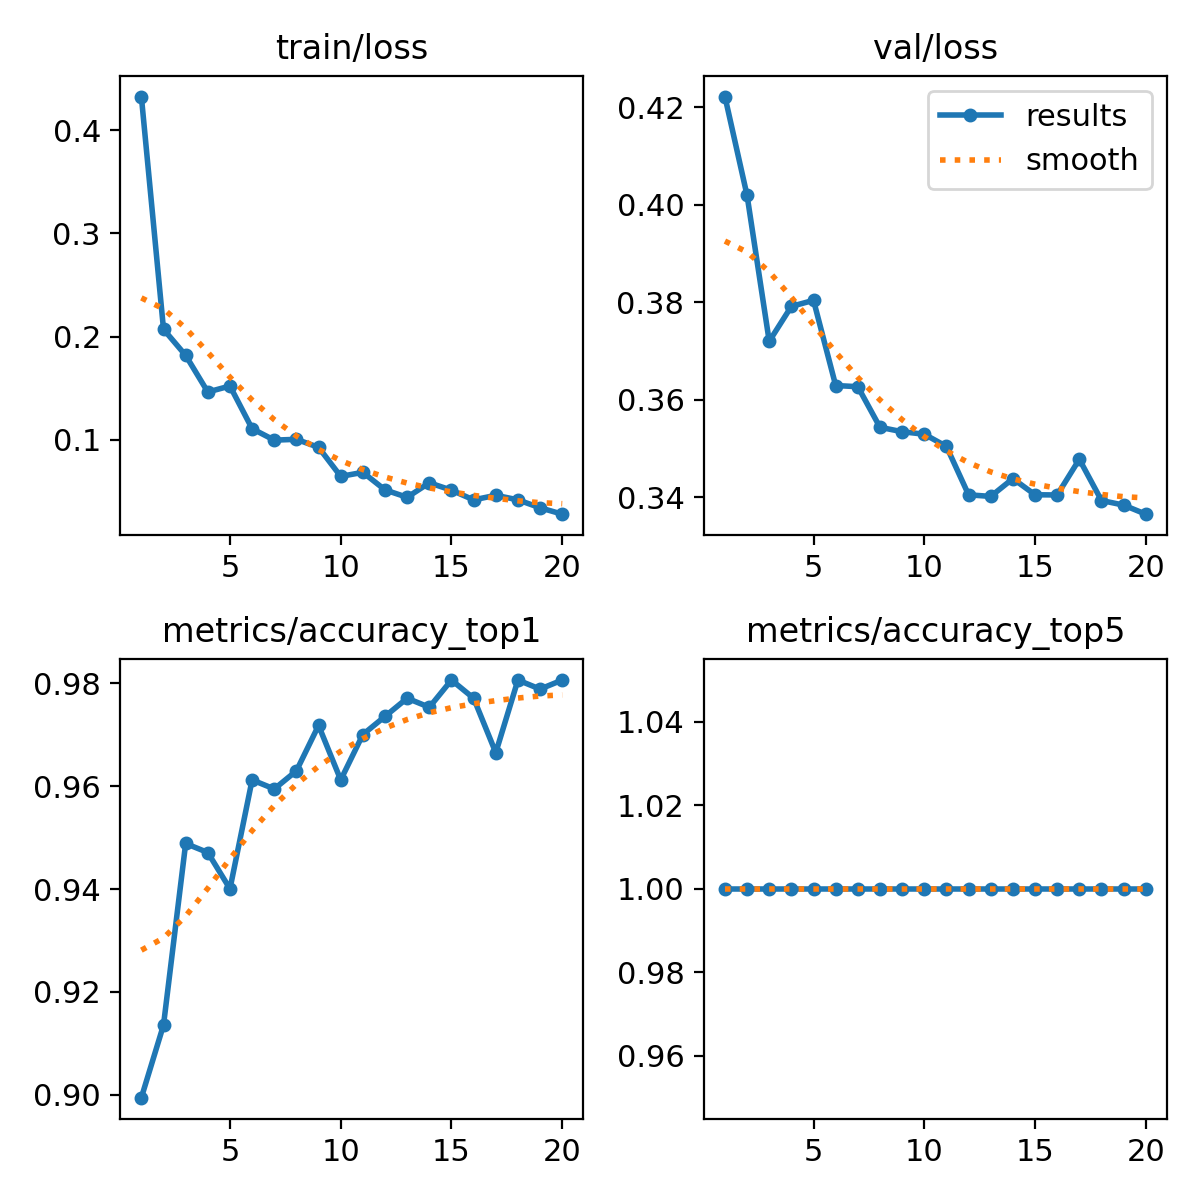

In [12]:
from IPython.display import Image
Image('/content/runs/classify/train/results.png')

# Test and validate model

Now I'd like to test how the model handles identifying the membership of different classes of animals. For this purpose I will use the data in the directory `panda-test/hand-testing`. The results of testing will be presented in the table below.

In [36]:
PANDA_TEST_DATA = "panda-data/hand-testing/red-panda"
NOPANDA_TEST_DATA = "panda-data/hand-testing/no-red-panda"
PANDA_CLASS_NAME = "red-panda"
NOPANDA_CLASS_NAME = "no-red-panda"

!echo "classes of no read panda animals:"
!ls panda-data/hand-testing/no-red-panda

classes of no read panda animals:
antelope     coyote	goldfish      kangaroo	 otter		 rat	       sparrow
badger	     crab	goose	      koala	 owl		 red-cat       squid
bat	     crow	gorilla       ladybugs	 ox		 red-dog       squirrel
bear	     deer	grasshopper   leopard	 oyster		 red-fox       starfish
bee	     dolphin	hamster       lion	 panda		 red-squirrel  swan
beetle	     donkey	hare	      lizard	 parrot		 reindeer      tiger
bison	     dragonfly	hedgehog      lobster	 pelecaniformes  rhinoceros    turkey
boar	     duck	hippopotamus  mosquito	 penguin	 sandpiper     turtle
butterfly    eagle	hornbill      moth	 pig		 seahorse      whale
caterpillar  elephant	horse	      mouse	 pigeon		 seal	       wolf
chimpanzee   flamingo	hummingbird   octopus	 porcupine	 shark	       wombat
cockroach    fly	hyena	      okapi	 possum		 sheep	       woodpecker
cow	     goat	jellyfish     orangutan  raccoon	 snake	       zebra


In [76]:
from ultralytics import YOLO

import numpy as np

class AnimalClass:
  def __init__(self, class_name: str, number_of_test_cases : int, accepted_cases : int, rejected_cases : int):
    self.class_name = class_name
    self.number_of_test_cases = number_of_test_cases
    self.accepted = accepted_cases
    self.rejected = rejected_cases

  @classmethod
  def from_class_dir(cls, model, class_dir : str, is_red_panda_class : bool) -> 'AnimalClass':

    class_name = class_dir.split("/").pop()
    number_of_test_cases = len(os.listdir(class_dir))
    accepted_cases, rejected_cases = 0, 0

    for animal_img in os.listdir(class_dir):
      animal_path = os.path.join(class_dir, animal_img)

      if os.path.isfile(animal_path):
        predict_result = model.predict(animal_path)[0]
        names = predict_result.names
        probs = predict_result.probs.data.tolist()
        predicted_class = names[np.argmax(probs)]

        if is_red_panda_class:
            if predicted_class == PANDA_CLASS_NAME:
              accepted_cases += 1
            else:
              rejected_cases += 1
        else:
            if predicted_class == NOPANDA_CLASS_NAME:
              accepted_cases += 1
            else:
              rejected_cases += 1

    return cls(class_name, number_of_test_cases, accepted_cases, rejected_cases)


In [ ]:
from ultralytics import YOLO

result = []
model = YOLO('/content/runs/classify/train/weights/last.pt')
result.append(AnimalClass.from_class_dir(model, PANDA_TEST_DATA, True))
for animal_class in os.listdir(NOPANDA_TEST_DATA):
  animal_class_path = os.path.join(NOPANDA_TEST_DATA, animal_class)
  if os.path.isdir(animal_class_path):
    result.append(AnimalClass.from_class_dir(model, animal_class_path, False))


In [89]:
import csv

RESULT_FILE = 'result.csv'

result.sort(key=lambda val: val.class_name)

with open(RESULT_FILE, 'w', newline='') as file:
  writer = csv.writer(file)
  fields = ['animal-class', 'images number', 'accepted', 'rejected', 'acceptance rate']
  writer.writerow(fields)
  total_images, total_accepted, total_rejected, total_acceptance_rate = 0, 0, 0, 0.0

  for animal_class in result:
    num = animal_class.number_of_test_cases
    accepted = animal_class.accepted
    rejected = animal_class.rejected
    acceptance_rate = accepted/float(num)
    writer.writerow([animal_class.class_name, str(num), str(accepted), str(rejected), '{:.0%}'.format(acceptance_rate)])
    total_images += num
    total_accepted += accepted
    total_rejected += rejected
    total_acceptance_rate += acceptance_rate

  writer.writerow(["total", str(total_images), str(total_accepted), str(total_rejected), '{:.0%}'.format(total_acceptance_rate/len(result))])


Results of model performance:

In [92]:
import pandas as pd

data = pd.read_csv(RESULT_FILE)
data

,animal-class,images number,accepted,rejected,acceptance rate
0,antelope,30,29,1,97%
1,badger,30,30,0,100%
2,bat,30,27,3,90%
3,bear,30,29,1,97%
4,bee,30,30,0,100%
...,...,...,...,...,...
88,wolf,30,30,0,100%
89,wombat,30,29,1,97%
90,woodpecker,30,30,0,100%
91,zebra,30,30,0,100%


By analyzing this table we can see that the model achieved good results on all classes of animals. Even with difficult classes (red fox, red cat, red dog, ...) it performs well. The total accuracy of the model is 98%.